In [79]:
# import libraries
import os
import pandas as pd
import numpy as np
import time
import datetime

from sklearn.preprocessing import MinMaxScaler
from sklearn.impute import SimpleImputer
# from sklearn.externals import joblib
import seaborn as sns
sns.set(color_codes=True)
import matplotlib.pyplot as plt
%matplotlib inline

%load_ext autoreload
%autoreload 2
from fortadGAN.fortadGAN_utils import score_anomalies, reconstruction_errors
from fortadGAN.fortadGAN_layers import build_encoder_layer, build_generator_layer, build_critic_x_layer, build_critic_z_layer, wasserstein_loss
from fortadGAN.fortadGAN_preproc import time_segments_aggregate, rolling_window_sequences


import tensorflow as tf
import logging
import math
from numpy.random import seed
# from tensorflow import set_random_seed
# tf.logging.set_verbosity(tf.logging.ERROR)


from keras.layers import Input, Dropout, Dense, LSTM, TimeDistributed, RepeatVector
from keras.models import Model
from keras import regularizers


# load, average and merge sensor samples
data_dir = 'data'
merged_data = pd.DataFrame()

for filename in os.listdir(data_dir):
    dataset = pd.read_csv(os.path.join(data_dir, filename), sep='\t')
    dataset_mean_abs = np.array(dataset.abs().mean())
    dataset_mean_abs = pd.DataFrame(dataset_mean_abs.reshape(1,4))
    dataset_mean_abs.index = [filename]
    merged_data = merged_data.append(dataset_mean_abs)
    
merged_data.columns = ['Bearing 1', 'Bearing 2', 'Bearing 3', 'Bearing 4']
merged_data.head()

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


,Bearing 1,Bearing 2,Bearing 3,Bearing 4
2004.02.16.16.22.39,0.073814,0.074713,0.075640,0.044425
2004.02.15.16.42.39,0.059662,0.073159,0.075952,0.042869
2004.02.17.16.52.39,0.092946,0.078138,0.077772,0.050036
2004.02.15.12.22.39,0.060525,0.074383,0.078142,0.044174
2004.02.17.02.42.39,0.078344,0.074184,0.079004,0.046181


In [80]:
merged_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 982 entries, 2004.02.16.16.22.39 to 2004.02.15.09.42.39
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Bearing 1  982 non-null    float64
 1   Bearing 2  982 non-null    float64
 2   Bearing 3  982 non-null    float64
 3   Bearing 4  982 non-null    float64
dtypes: float64(4)
memory usage: 38.4+ KB


In [81]:
merged_data.index = pd.to_datetime(merged_data.index, format='%Y.%m.%d.%H.%M.%S')
merged_data = merged_data.sort_index()
train = merged_data['2004-02-12 10:52:39': '2004-02-15 12:52:39']
test = merged_data['2004-02-15 12:52:39':]


In [82]:
df = merged_data.rename_axis('timestamp').reset_index()

converted = list()
for t in df['timestamp']:
    timestamp = time.mktime(t.timetuple())
    converted.append(int(timestamp))

df['timestamp'] = converted

df.head()

# merged_data.rename_axis('timestamp').reset_index()
# merged_data.head()

,timestamp,Bearing 1,Bearing 2,Bearing 3,Bearing 4
0,1076550759,0.060236,0.074227,0.083926,0.044443
1,1076551359,0.061455,0.073844,0.084457,0.045081
2,1076551959,0.061361,0.075609,0.082837,0.045118
3,1076552559,0.061665,0.073279,0.084879,0.044172
4,1076553159,0.061944,0.074593,0.082626,0.044659


In [83]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 982 entries, 0 to 981
Data columns (total 5 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   timestamp  982 non-null    int64  
 1   Bearing 1  982 non-null    float64
 2   Bearing 2  982 non-null    float64
 3   Bearing 3  982 non-null    float64
 4   Bearing 4  982 non-null    float64
dtypes: float64(4), int64(1)
memory usage: 38.5 KB


In [ ]:
# test_tsa = df.sort_values('timestamp').set_index('timestamp')
# start_ts = test_tsa.index.values[0]
# max_ts = test_tsa.index.values[-1]
# # print(start_ts)
# # print(max_ts)

# values = list()
# index = list()
# num = 0
# while start_ts <= max_ts:
#         end_ts = start_ts + 600
#         subset = test_tsa.loc[start_ts:end_ts - 1]
#         # subset = test_tsa.loc[start_ts:end_ts]
#         print(subset.shape)
#         # aggregated = [
#         #     getattr(subset, agg)(skipna=True).values
#         #     for agg in ['mean']
#         # ]
#         # values.append(np.concatenate(aggregated))
#         # index.append(start_ts)
#         start_ts = end_ts
#         num+=1
#         print(num)

In [90]:
# 전처리 
X, index = time_segments_aggregate(df, interval=600, time_column='timestamp')
print(len(X))
print(len(index))
imp = SimpleImputer()
X = imp.fit_transform(X)
scaler = MinMaxScaler(feature_range=(-1, 1))
X = scaler.fit_transform(X)
X, y = rolling_window_sequences(X, index, 
                                window_size=100, 
                                target_size=1, 
                                step_size=1)
print("Training data input shape: {}".format(X.shape))
print("Training y shape: {}".format(y.shape))
# X, y, X_index, y_index = rolling_window_sequences(X, index, 
#                                                   window_size=100, 
#                                                   target_size=1, 
#                                                   step_size=1)
# print("Training data input shape: {}".format(X.shape))
# print("Training data index shape: {}".format(X_index.shape))
# print("Training y shape: {}".format(y.shape))
# print("Training y index shape: {}".format(y_index.shape))
LOGGER = logging.getLogger(__name__)


982
982
Training data input shape: (883, 100, 4)
Training y shape: (883,)


/home/rain/anaconda3/envs/tf2/lib/python3.6/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


In [91]:
window_size = 100
latent_dim = 20
shape = (window_size, 4)

# Train parameters
batch_size = 64
n_critics = 5
epochs = 10

# Layer Parameters
encoder_input_shape = (window_size, 4)
generator_input_shape = (20, 4)

critic_x_input_shape = (window_size, 4)
critic_z_input_shape = (20,4)

encoder_reshape_shape = (20, 4)
generator_reshape_shape = (window_size//2, 4) # window_size//3 <- 3 is Upsampling size

learning_rate = 0.0005

# Build Model
encoder = build_encoder_layer(input_shape=encoder_input_shape,
                              encoder_reshape_shape=encoder_reshape_shape)

generator = build_generator_layer(input_shape=generator_input_shape,
                                  generator_reshape_shape=generator_reshape_shape)

critic_x = build_critic_x_layer(input_shape=critic_x_input_shape)
critic_z = build_critic_z_layer(input_shape=critic_z_input_shape)

encoder_optimizer = tf.keras.optimizers.Adam(learning_rate)
generator_optimizer = tf.keras.optimizers.Adam(learning_rate)
critic_x_optimizer = tf.keras.optimizers.Adam(learning_rate)
critic_z_optimizer = tf.keras.optimizers.Adam(learning_rate)

In [92]:
@tf.function
def critic_x_train_on_batch(x, z):
    # Loss 크게 이상 없음 
    with tf.GradientTape() as tape:
        x_ = generator(z)
        valid_x = critic_x(x)
        fake_x = critic_x(x_)
        
        # Interpolated 
        alpha = tf.random.uniform([batch_size, 1, 1], 0.0, 1.0)
        interpolated = alpha * x + (1 - alpha) * x_ 
        
        with tf.GradientTape() as gp_tape:
            gp_tape.watch(interpolated)
            pred = critic_x(interpolated)
        
        grads = gp_tape.gradient(pred, interpolated)
        grad_norm = tf.norm(tf.reshape(grads, (batch_size, -1)), axis=1)
        gp_loss = 10.0*tf.reduce_mean(tf.square(grad_norm - 1.))
                
        loss1 = wasserstein_loss(-tf.ones_like(valid_x), valid_x)
        loss2 = wasserstein_loss(tf.ones_like(fake_x), fake_x)
        loss = loss1 + loss2 + gp_loss
                        
    gradients = tape.gradient(loss, critic_x.trainable_weights)
    critic_x_optimizer.apply_gradients(zip(gradients, critic_x.trainable_weights))
    return loss


@tf.function
def critic_z_train_on_batch(x, z):
    
    with tf.GradientTape() as tape:

        z_ = encoder(x)   
        valid_z = critic_z(z)             
        fake_z = critic_z(z_) # <- critic_z 의 결과가 매우 않음 
        
        # Interpolated 
        alpha = tf.random.uniform([batch_size, 1, 1], 0.0, 1.0)
        interpolated = alpha * z + (1 - alpha) * z_ 
                
        with tf.GradientTape() as gp_tape:
            gp_tape.watch(interpolated)
            pred = critic_z(interpolated, training=True)
            
        grads = gp_tape.gradient(pred, interpolated)
        grad_norm = tf.norm(tf.reshape(grads, (batch_size, -1)), axis=1)
        gp_loss = 10.0*tf.reduce_mean(tf.square(grad_norm - 1.))
        
        loss1 = wasserstein_loss(-tf.ones_like(valid_z), valid_z)
        loss2 = wasserstein_loss(tf.ones_like(fake_z), fake_z) # <- 이게 미친듯이 뜀. 
        loss = loss1 + loss2 + gp_loss
        
    gradients = tape.gradient(loss, critic_z.trainable_weights)
    critic_z_optimizer.apply_gradients(zip(gradients, critic_z.trainable_weights))
    return loss


@tf.function
def enc_gen_train_on_batch(x, z):
    with tf.GradientTape() as enc_tape:
        
        z_gen_ = encoder(x, training=True)
        x_gen_ = generator(z, training=False)        
        x_gen_rec = generator(z_gen_, training=False)
        
        fake_gen_x = critic_x(x_gen_, training=False)
        fake_gen_z = critic_z(z_gen_, training=False)
        
        loss1 = wasserstein_loss(fake_gen_x, -tf.ones_like(fake_gen_x))
        loss2 = wasserstein_loss(fake_gen_z, -tf.ones_like(fake_gen_z))
        loss3 = 10.0*tf.reduce_mean(tf.keras.losses.MSE(x, x_gen_rec))

        enc_loss = loss1 + loss2 + loss3
        
    gradients_encoder = enc_tape.gradient(enc_loss, encoder.trainable_weights)
    encoder_optimizer.apply_gradients(zip(gradients_encoder, encoder.trainable_weights))

    with tf.GradientTape() as gen_tape:
        
        z_gen_ = encoder(x, training=False)
        x_gen_ = generator(z, training=True)        
        x_gen_rec = generator(z_gen_, training=True)
        
        fake_gen_x = critic_x(x_gen_, training=False)
        fake_gen_z = critic_z(z_gen_, training=False)
        
        loss1 = wasserstein_loss(fake_gen_x, -tf.ones_like(fake_gen_x))
        loss2 = wasserstein_loss(fake_gen_z, -tf.ones_like(fake_gen_z))
        loss3 = 10.0*tf.reduce_mean(tf.keras.losses.MSE(x, x_gen_rec))

        gen_loss = loss1 + loss2 + loss3
        
    gradients_generator = gen_tape.gradient(gen_loss, generator.trainable_weights)    
    generator_optimizer.apply_gradients(zip(gradients_generator, generator.trainable_weights))    
    return enc_loss, gen_loss

In [93]:
tf.config.experimental_run_functions_eagerly(True)

X = X.reshape((-1, shape[0], 4))
X_ = np.copy(X)

print("Training data input shape: {}".format(X.shape))
# print("Training data index shape: {}".format(X_index.shape))
print("Training y shape: {}".format(y.shape))
# print("Training y index shape: {}".format(y_index.shape))

Training data input shape: (883, 100, 4)
Training data index shape: (882,)
Training y shape: (883,)
Training y index shape: (882,)


In [94]:
epoch_e_loss = []    
epoch_g_loss = []
epoch_cx_loss = []
epoch_cz_loss = []

for epoch in range(1, epochs+1):
    
    np.random.shuffle(X_)
    
    minibatches_size = batch_size * n_critics  # 64*5 = 320 
    num_minibatches = int(X_.shape[0] // minibatches_size)  # 12 
    
    encoder.trainable = False
    generator.trainable = False
    
    for i in range(num_minibatches):
        minibatch = X_[i * minibatches_size: (i + 1) * minibatches_size]
        
        # Number of Critics 
        for j in range(n_critics):
            
            x = minibatch[j * batch_size: (j + 1) * batch_size]
            ## 임의의 신호를 만들어서 집어 넣어주는 단계 (GAN을 학습시키기 위해 존재함)
            z = tf.random.normal(shape=(batch_size, latent_dim, 4), mean=0.0, stddev=1, dtype=tf.dtypes.float32, seed=1748)

            
            critic_x.trainable = True
            critic_z.trainable = False
            epoch_cx_loss.append(critic_x_train_on_batch(x, z))
            critic_x.trainable = False
            critic_z.trainable = True
            epoch_cz_loss.append(critic_z_train_on_batch(x, z))
        
        critic_z.trainable = False
        critic_x.trainable = False
        encoder.trainable = True
        generator.trainable = True
        
        enc_loss, gen_loss = enc_gen_train_on_batch(x, z)
        epoch_e_loss.append(enc_loss)
        epoch_g_loss.append(gen_loss)
        
    cx_loss = np.mean(np.array(epoch_cx_loss), axis=0)
    cz_loss = np.mean(np.array(epoch_cz_loss), axis=0)
    e_loss = np.mean(np.array(epoch_e_loss), axis=0)
    g_loss = np.mean(np.array(epoch_g_loss), axis=0)
    
    print('Epoch: {}/{}, [Dx loss: {}] [Dz loss: {}] [E loss: {}] [G loss: {}]'.format(epoch, epochs, cx_loss, cz_loss, e_loss, g_loss))    

Epoch: 1/10, [Dx loss: 5.6461591720581055] [Dz loss: 0.41366448998451233] [E loss: 0.5692867040634155] [G loss: -1.326209306716919]
Epoch: 2/10, [Dx loss: 2.053725242614746] [Dz loss: 1.2604657411575317] [E loss: -0.5697077512741089] [G loss: -2.419991970062256]
Epoch: 3/10, [Dx loss: -0.15697194635868073] [Dz loss: 1.1822984218597412] [E loss: -0.7038090229034424] [G loss: -2.3554491996765137]
Epoch: 4/10, [Dx loss: -1.3819530010223389] [Dz loss: -0.001041758107021451] [E loss: 0.47259920835494995] [G loss: -1.0944297313690186]
Epoch: 5/10, [Dx loss: -2.146836042404175] [Dz loss: -1.9155648946762085] [E loss: 2.351597309112549] [G loss: 0.6199652552604675]
Epoch: 6/10, [Dx loss: -2.60983943939209] [Dz loss: -3.7042360305786133] [E loss: 4.220156192779541] [G loss: 2.2242929935455322]
Epoch: 7/10, [Dx loss: -2.824755907058716] [Dz loss: -5.045318126678467] [E loss: 5.568861961364746] [G loss: 3.35937237739563]
Epoch: 8/10, [Dx loss: -2.846383571624756] [Dz loss: -5.8394060134887695] [E

In [36]:
X_index.shape

(882,)

In [32]:
st = (X_index[1]-X_index[0])/100




6.0


In [50]:
# pred_length = X_gen.shape[1] # 100
# num_errors = X_gen.shape[1] + 1 * (X_gen.shape[0] - 1) # 981
# print(pred_length) # 100
# print(num_errors) #981
num_errors=10
pred_length=3

for i in range(num_errors):
    print(i, '#############')
    for j in range(max(0, i - num_errors + pred_length), min(i + 1, pred_length)):
        print([i - j, j])

0 #############
[0, 0]
1 #############
[1, 0]
[0, 1]
2 #############
[2, 0]
[1, 1]
[0, 2]
3 #############
[3, 0]
[2, 1]
[1, 2]
4 #############
[4, 0]
[3, 1]
[2, 2]
5 #############
[5, 0]
[4, 1]
[3, 2]
6 #############
[6, 0]
[5, 1]
[4, 2]
7 #############
[7, 0]
[6, 1]
[5, 2]
8 #############
[7, 1]
[6, 2]
9 #############
[7, 2]


In [35]:
a = 0
b = 10
stam = []
st = (b-a)/10
for i in range(10-1):
    stam.append(i*st+a)
# print(len(stam))

9


In [41]:
num_errors = X_gen.shape[1] + 1 * (X_gen.shape[0] - 1)
(X_gen.shape[0] - 1)
X_gen.shape[1]

100

In [76]:
X.shape
X[0][0].shape

(4,)

In [78]:
# smoothing_window = 0.01

# if isinstance(smoothing_window, float):
#     smoothing_window = min(math.trunc(len(X) * smoothing_window), 200)

# # 온전한 데이터로 복원 (온전하지 못하다!!!)
# ## univariate 기준으로 작성되었기 때문에 수정이 추가로 필요함
true = [item[0] for item in X]
print(len(true))
print(true[0].shape)
print(len(X[-1][1:]))
for item in X[-1][1:]:
    true.append(item)
print(len(true))

predictions = []
pred_length = X_gen.shape[1] # 100
num_errors = X_gen.shape[1] + 1 * (X_gen.shape[0] - 1) # 981

for i in range(num_errors):
    intermediate = []
    for j in range(max(0, i - num_errors + pred_length), min(i + 1, pred_length)):
        intermediate.append(X_gen[i - j, j])
    if intermediate:
        predictions.append(np.median(np.asarray(intermediate), axis=0))

# true = np.asarray(true)
# predictions = np.asarray(predictions)

# print(true.shape)
# print(predictions.shape)




# errors = _dtw_error(true, predictions)

882
(4,)
99
981


In [12]:
# import math
# from matplotlib.pyplot import axis
# import numpy as np
# import pandas as pd
# # from pyts.metrics import dtw
# from scipy import integrate
# from scipy import stats
# from pyts.metrics import dtw

# def score_anomalies(y, y_hat, critic, score_window=10, critic_smooth_window=None,
#                     error_smooth_window=None, smooth=True, rec_error_type="point", comb="mult",
#                     lambda_rec=0.5):
#     """Compute an array of anomaly scores.

#     Anomaly scores are calculated using a combination of reconstruction error and critic score.

#     Args:
#         y (ndarray):
#             Ground truth.
#         y_hat (ndarray):
#             Predicted values. Each timestamp has multiple predictions.
#         index (ndarray):
#             time index for each y (start position of the window)
#         critic (ndarray):
#             Critic score. Each timestamp has multiple critic scores.
#         score_window (int):
#             Optional. Size of the window over which the scores are calculated.
#             If not given, 10 is used.
#         critic_smooth_window (int):
#             Optional. Size of window over which smoothing is applied to critic.
#             If not given, 200 is used.
#         error_smooth_window (int):
#             Optional. Size of window over which smoothing is applied to error.
#             If not given, 200 is used.
#         smooth (bool):
#             Optional. Indicates whether errors should be smoothed.
#             If not given, `True` is used.
#         rec_error_type (str):
#             Optional. The method to compute reconstruction error. Can be one of
#             `["point", "area", "dtw"]`. If not given, 'point' is used.
#         comb (str):
#             Optional. How to combine critic and reconstruction error. Can be one
#             of `["mult", "sum", "rec"]`. If not given, 'mult' is used.
#         lambda_rec (float):
#             Optional. Used if `comb="sum"` as a lambda weighted sum to combine
#             scores. If not given, 0.5 is used.

#     Returns:
#         ndarray:
#             Array of anomaly scores.
#     """

#     critic_smooth_window = critic_smooth_window or math.trunc(y.shape[0] * 0.01)
#     error_smooth_window = error_smooth_window or math.trunc(y.shape[0] * 0.01)

#     step_size = 1  # expected to be 1

#     # true_index = index  # no offset

#     # true = [item[0] for item in y]
#     # for item in y[-1][1:]:
#     #     true.append(item)

#     ## ctiric 추가 계산
#     critic_extended = list()
#     for c in critic:
#         critic_extended.extend(np.repeat(c, y_hat.shape[1]).tolist())
#     critic_extended = np.asarray(critic_extended).reshape((-1, y_hat.shape[1]))
    
#     critic_kde_max = []
#     pred_length = y_hat.shape[1]
#     num_errors = y_hat.shape[1] + step_size * (y_hat.shape[0] - 1)

#     for i in range(num_errors):
#         critic_intermediate = []

#         for j in range(max(0, i - num_errors + pred_length), min(i + 1, pred_length)):
#             critic_intermediate.append(critic_extended[i - j, j])

#         if len(critic_intermediate) > 1:
#             discr_intermediate = np.asarray(critic_intermediate)
#             try:
#                 critic_kde_max.append(discr_intermediate[np.argmax(
#                     stats.gaussian_kde(discr_intermediate)(critic_intermediate))])
#             except np.linalg.LinAlgError:
#                 critic_kde_max.append(np.median(discr_intermediate))
#         else:
#             critic_kde_max.append(np.median(np.asarray(critic_intermediate)))

#     # Compute critic scores
#     critic_scores = _compute_critic_score(critic_kde_max, critic_smooth_window)

#     # Compute reconstruction scores
#     rec_scores = reconstruction_errors(
#         y, y_hat, step_size, score_window, error_smooth_window, smooth, rec_error_type)
#     rec_scores = stats.zscore(rec_scores)
#     rec_scores = np.clip(rec_scores, a_min=0, a_max=None) + 1

#     if rec_scores.shape[1] >1:
#         new_critic_scores = []
#         for i in range(rec_scores.shape[1]):
#             new_critic_scores.append(critic_scores)
#         # critic_scores = np.repeat(critic_score, axis=1)
#         critic_scores = np.transpose(np.asarray(new_critic_scores))

#     # Combine the two scores
#     if comb == "mult":
#         final_scores = np.multiply(critic_scores, rec_scores)

#     elif comb == "sum":
#         final_scores = (1 - lambda_rec) * (critic_scores - 1) + lambda_rec * (rec_scores - 1)

#     elif comb == "rec":
#         final_scores = rec_scores

#     else:
#         raise ValueError(
#             'Unknown combination specified {}, use "mult", "sum", or "rec" instead.'.format(comb))

#     # true = np.asarray([[t] for t in true])
#     return final_scores


# def reconstruction_errors(y, y_hat, step_size=1, score_window=10, smoothing_window=0.01,
#                           smooth=True, rec_error_type='point'):
#     """Compute an array of reconstruction errors.

#         Compute the discrepancies between the expected and the
#         predicted values according to the reconstruction error type.

#         Args:
#             y (ndarray):
#                 Ground truth.
#             y_hat (ndarray):
#                 Predicted values. Each timestamp has multiple predictions.
#             step_size (int):
#                 Optional. Indicating the number of steps between windows in the predicted values.
#                 If not given, 1 is used.
#             score_window (int):
#                 Optional. Size of the window over which the scores are calculated.
#                 If not given, 10 is used.
#             smoothing_window (float or int):
#                 Optional. Size of the smoothing window, when float it is expressed as a proportion
#                 of the total length of y. If not given, 0.01 is used.
#             smooth (bool):
#                 Optional. Indicates whether the returned errors should be smoothed.
#                 If not given, `True` is used.
#             rec_error_type (str):
#                 Optional. Reconstruction error types ``["point", "area", "dtw"]``.
#                 If not given, "point" is used.

#         Returns:
#             ndarray:
#                 Array of reconstruction errors.
#         """
#     if isinstance(smoothing_window, float):
#         smoothing_window = min(math.trunc(len(y) * smoothing_window), 200)

#     # 온전한 데이터로 복원 (온전하지 못하다!!!)
#     ## univariate 기준으로 작성되었기 때문에 수정이 추가로 필요함
#     true = [item[0] for item in y]
#     for item in y[-1][1:]:
#         true.append(item)

#     predictions = []
#     pred_length = y_hat.shape[1]
#     num_errors = y_hat.shape[1] + step_size * (y_hat.shape[0] - 1)

#     for i in range(num_errors):
#         intermediate = []
#         for j in range(max(0, i - num_errors + pred_length), min(i + 1, pred_length)):
#             intermediate.append(y_hat[i - j, j])
#         if intermediate:
#             predictions.append(np.median(np.asarray(intermediate), axis=0))

#     true = np.asarray(true)
#     predictions = np.asarray(predictions)

#     # Compute reconstruction errors
#     if rec_error_type.lower() == "point":
#         errors = _point_wise_error(true, predictions)

#     elif rec_error_type.lower() == "area":
#         errors = _area_error(true, predictions, score_window)

#     elif rec_error_type.lower() == "dtw":
#         errors = _dtw_error(true, predictions, score_window)

#     # Apply smoothing
#     if smooth:
#         if len(errors.shape) >1:
#             each_errors = []
#             for ec in range(errors.shape[1]):
#                 smooth_ec = pd.Series(errors[:,ec]).rolling(
#                     smoothing_window, center=True, min_periods=smoothing_window // 2).mean().values
#                 each_errors.append(smooth_ec)
#             each_errors = np.transpose(np.asarray(each_errors))
#         else:
#             each_errors = pd.Series(errors).rolling(
#             smoothing_window, center=True, min_periods=smoothing_window // 2).mean().values
#     return each_errors

# def _compute_critic_score(critics, smooth_window):
#     """Compute an array of anomaly scores.

#     Args:
#         critics (ndarray):
#             Critic values.
#         smooth_window (int):
#             Smooth window that will be applied to compute smooth errors.

#     Returns:
#         ndarray:
#             Array of anomaly scores.
#     """
#     critics = np.asarray(critics)
#     l_quantile = np.quantile(critics, 0.25)
#     u_quantile = np.quantile(critics, 0.75)
#     in_range = np.logical_and(critics >= l_quantile, critics <= u_quantile)
#     critic_mean = np.mean(critics[in_range])
#     critic_std = np.std(critics)

#     z_scores = np.absolute((np.asarray(critics) - critic_mean) / critic_std) + 1
#     z_scores = pd.Series(z_scores).rolling(
#         smooth_window, center=True, min_periods=smooth_window // 2).mean().values

#     return z_scores

# def _point_wise_error(y, y_hat):
#     """Compute point-wise error between predicted and expected values.

#     The computed error is calculated as the difference between predicted
#     and expected values with a rolling smoothing factor.

#     Args:
#         y (ndarray):
#             Ground truth.
#         y_hat (ndarray):
#             Predicted values.

#     Returns:
#         ndarray:
#             An array of smoothed point-wise error.
#     """
#     return abs(y - y_hat)


# def _area_error(y, y_hat, score_window=10):
#     """Compute area error between predicted and expected values.

#     The computed error is calculated as the area difference between predicted
#     and expected values with a smoothing factor.

#     Args:
#         y (ndarray):
#             Ground truth.
#         y_hat (ndarray):
#             Predicted values.
#         score_window (int):
#             Optional. Size of the window over which the scores are calculated.
#             If not given, 10 is used.

#     Returns:
#         ndarray:
#             An array of area error.
#     """
#     each_errors = []
#     for ec in range(y.shape[1]):
#         smooth_y = pd.Series(y[:,ec]).rolling(
#             score_window, center=True, min_periods=score_window // 2).apply(integrate.trapz)
#         smooth_y_hat = pd.Series(y_hat[:,ec]).rolling(
#             score_window, center=True, min_periods=score_window // 2).apply(integrate.trapz)
#         errors = abs(smooth_y - smooth_y_hat)
#         each_errors.append(errors)
#     each_errors = np.transpose(np.asarray(each_errors))

#     return each_errors


# def _dtw_error(y, y_hat, score_window=10):
#     """Compute dtw error between predicted and expected values.

#     The computed error is calculated as the dynamic time warping distance
#     between predicted and expected values with a smoothing factor.

#     Args:
#         y (ndarray):
#             Ground truth.
#         y_hat (ndarray):
#             Predicted values.
#         score_window (int):
#             Optional. Size of the window over which the scores are calculated.
#             If not given, 10 is used.

#     Returns:
#         ndarray:
#             An array of dtw error.
#     """
#     length_dtw = (score_window // 2) * 2 + 1
#     half_length_dtw = length_dtw // 2


#     # add padding
#     print(y.shape)
#     print(y_hat.shape)
#     y_pad = np.pad(y, (half_length_dtw, half_length_dtw),
#                    'constant', constant_values=(0, 0))
#     y_hat_pad = np.pad(y_hat, (half_length_dtw, half_length_dtw),
#                        'constant', constant_values=(0, 0))

#     each_errors = list()
#     for ec in range(y.shape[1]):
#         ec_y_pad = y_pad[:,ec]
#         ec_y_hat_pad = y_hat_pad[:,ec]

#         i = 0
#         similarity_dtw = list()
#         while i < len(y) - length_dtw:
#             true_data = ec_y_pad[i:i + length_dtw]
#             true_data = true_data.flatten()

#             pred_data = ec_y_hat_pad[i:i + length_dtw]
#             pred_data = pred_data.flatten()

#             dist = dtw(true_data, pred_data)
#             similarity_dtw.append(dist)

#             i += 1

#         errors = ([0] * half_length_dtw + similarity_dtw +
#                 [0] * (len(y) - len(similarity_dtw) - half_length_dtw))
#         each_errors.append(errors)
#     each_errors = np.transpose(np.asarray(each_errors))
#     return each_errors




In [139]:


def reconstruction(X):
    z_gen_ = encoder(X, training=False)
    x_gen_ = generator(z_gen_, training=False)
    X_critic = critic_x(x_gen_, training=False)
    return x_gen_, X_critic

X_gen, X_critic = reconstruction(X)

final_scores = score_anomalies(X, X_gen, X_critic, rec_error_type="area", comb="mult")


In [98]:
# new_time = pd.to_datetime(df['timestamp'], format='%Y.%m.%d.%H.%M.%S')
# new_time

from datetime import datetime
def convert_date(timelist):
    converted = list()
    for x in timelist:
        converted.append(datetime.fromtimestamp(x))
    return converted

new_time = convert_date(df['timestamp'])
# new_time

In [135]:
final_scores

array([[ 1.21289021,  1.21289021,  1.21289021,  1.21289021],
       [ 1.22724298,  1.21242456,  1.21242456,  1.21242456],
       [ 1.27046886,  1.21211412,  1.21211412,  1.21211412],
       ...,
       [31.10101758, 20.58119951, 16.64231426, 22.84134327],
       [27.79664925, 18.3328887 , 14.61523864, 19.9457869 ],
       [24.0109351 , 15.76147221, 12.2492178 , 16.85550968]])

# point error

/home/rain/anaconda3/envs/tf2/lib/python3.6/site-packages/pandas/plotting/_matplotlib/core.py:486: UserWarning: Attempted to set non-positive bottom ylim on a log-scaled axis.
Invalid limit will be ignored.
  ax.set_ylim(self.ylim)


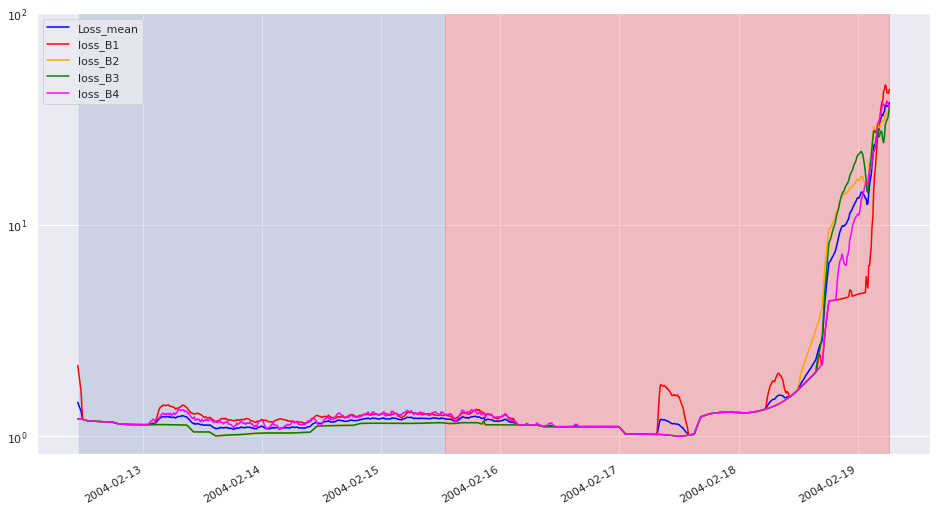

In [118]:
diff = np.mean(final_scores, axis=1)
scored = pd.DataFrame(index=new_time)
scored['Loss_mean']=diff
scored['loss_B1'] = final_scores[:,0]
scored['loss_B2'] = final_scores[:,1]
scored['loss_B3'] = final_scores[:,2]
scored['loss_B4'] = final_scores[:,3]

scored.plot(logy=True,  figsize=(16,9), ylim=[0,1e2], color=['blue','red', 'orange', 'green', 'magenta'])
plt.axvspan(train.index[0], train.index[-1], alpha=0.2)
plt.axvspan(test.index[0], test.index[-1], color='red', alpha=0.2)


# dtw error

/home/rain/anaconda3/envs/tf2/lib/python3.6/site-packages/pandas/plotting/_matplotlib/core.py:486: UserWarning: Attempted to set non-positive bottom ylim on a log-scaled axis.
Invalid limit will be ignored.
  ax.set_ylim(self.ylim)


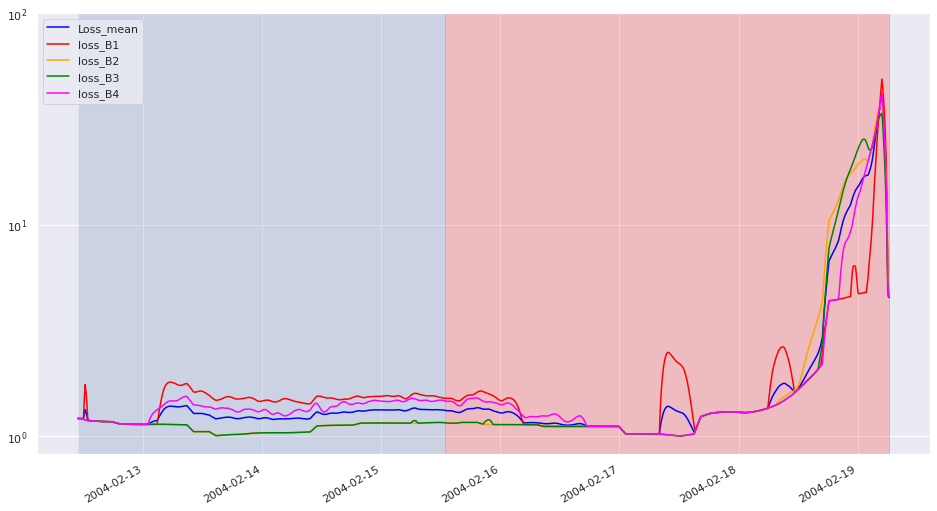

In [133]:
diff = np.mean(final_scores, axis=1)
scored = pd.DataFrame(index=new_time)
scored['Loss_mean']=diff
scored['loss_B1'] = final_scores[:,0]
scored['loss_B2'] = final_scores[:,1]
scored['loss_B3'] = final_scores[:,2]
scored['loss_B4'] = final_scores[:,3]

scored.plot(logy=True,  figsize=(16,9), ylim=[0,1e2], color=['blue','red', 'orange', 'green', 'magenta'])
plt.axvspan(train.index[0], train.index[-1], alpha=0.2)
plt.axvspan(test.index[0], test.index[-1], color='red', alpha=0.2)

# area error

/home/rain/anaconda3/envs/tf2/lib/python3.6/site-packages/pandas/plotting/_matplotlib/core.py:486: UserWarning: Attempted to set non-positive bottom ylim on a log-scaled axis.
Invalid limit will be ignored.
  ax.set_ylim(self.ylim)


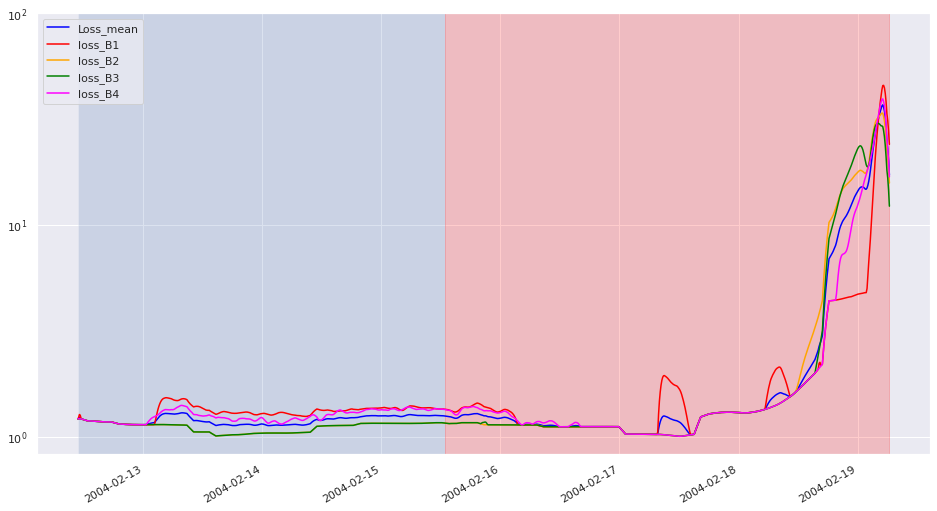

In [140]:
diff = np.mean(final_scores, axis=1)
scored = pd.DataFrame(index=new_time)
scored['Loss_mean']=diff
scored['loss_B1'] = final_scores[:,0]
scored['loss_B2'] = final_scores[:,1]
scored['loss_B3'] = final_scores[:,2]
scored['loss_B4'] = final_scores[:,3]

scored.plot(logy=True,  figsize=(16,9), ylim=[0,1e2], color=['blue','red', 'orange', 'green', 'magenta'])
plt.axvspan(train.index[0], train.index[-1], alpha=0.2)
plt.axvspan(test.index[0], test.index[-1], color='red', alpha=0.2)